In [12]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import random
import torchvision.transforms as transforms



In [15]:
dataset_path = 'C:\\Users\\anu\\Downloads\\bloodcells_dataset'

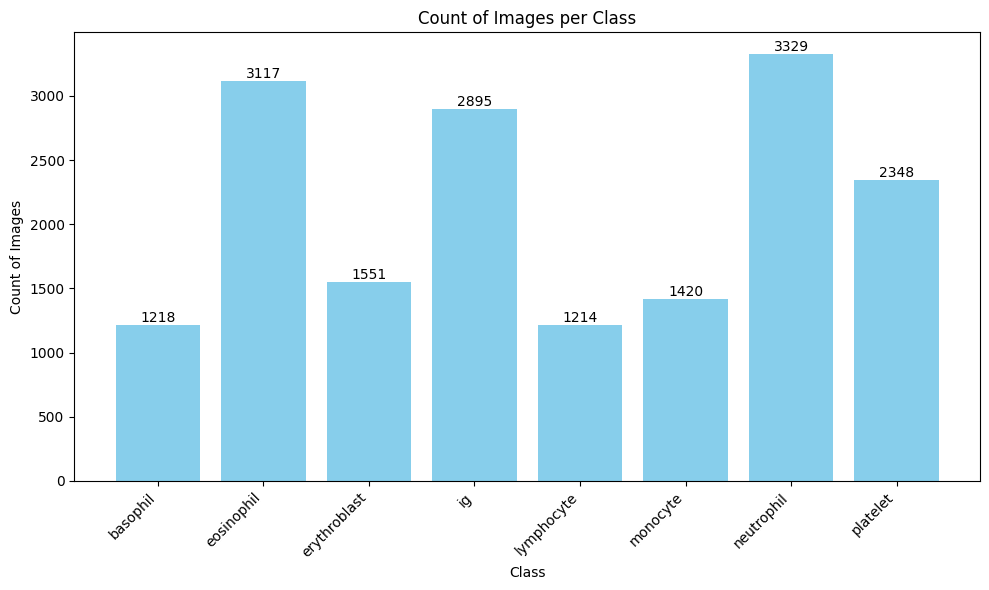

In [16]:
# Counting images per class
class_names = []
counts = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_files = len([filename for filename in os.listdir(class_dir)
                         if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
        class_names.append(class_name)
        counts.append(num_files)

# Displaying bar plot for counting images per class
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, color='skyblue')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', color='black')
plt.xlabel('Class')
plt.ylabel('Count of Images')
plt.title('Count of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


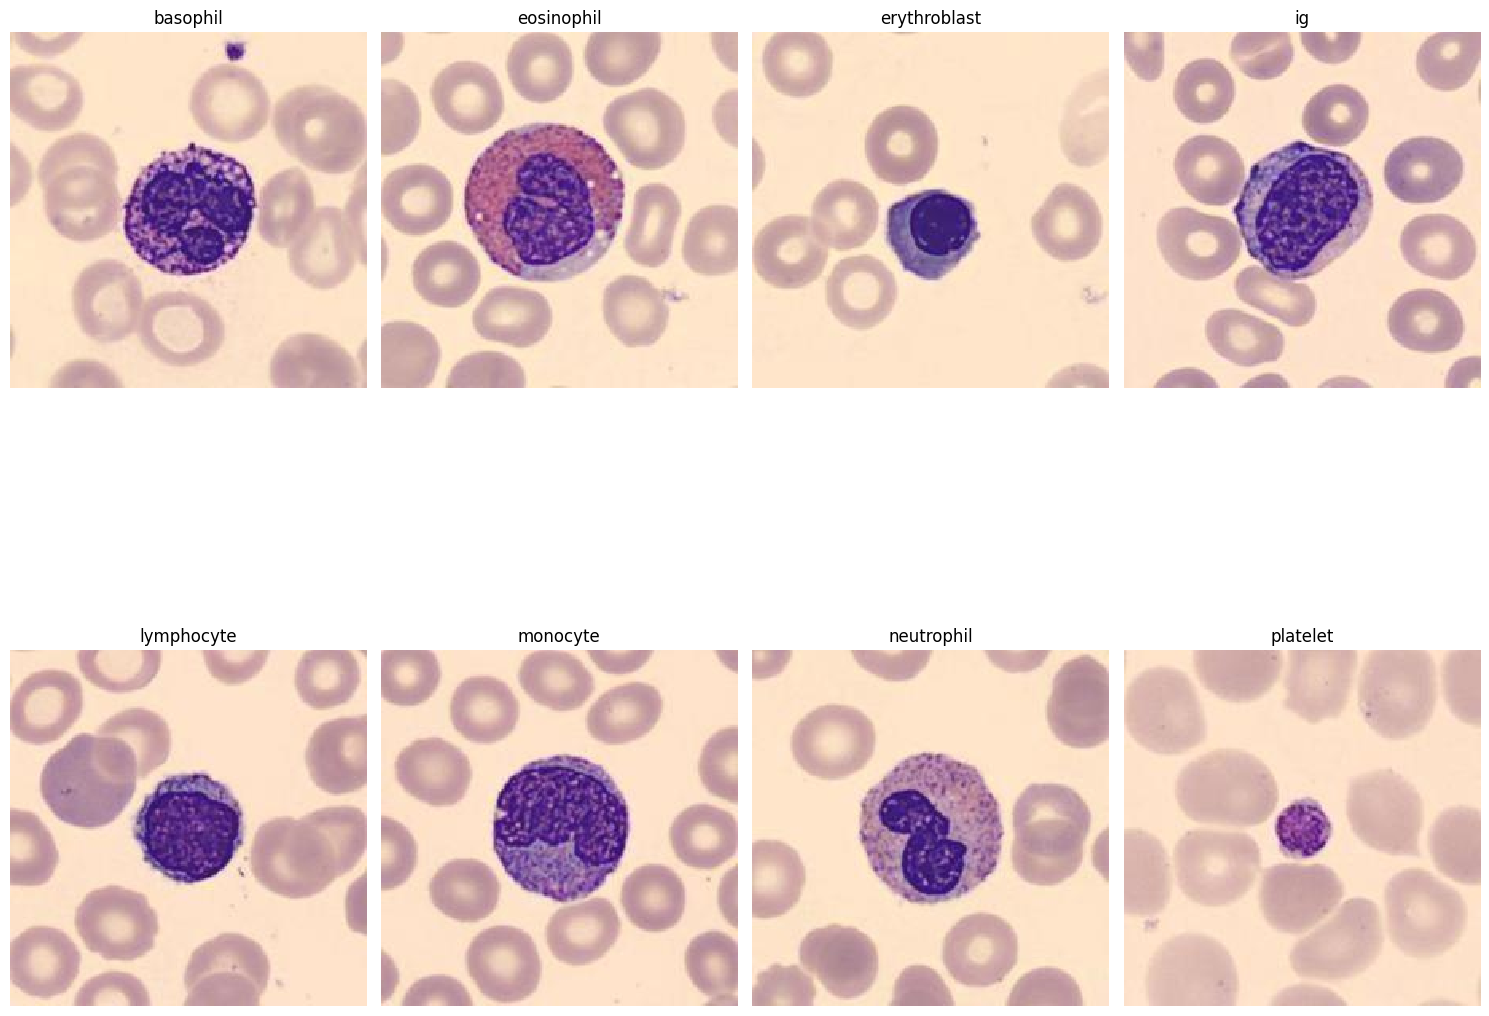

In [17]:
# Displaying random images per class
num_rows = 2
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
classes = os.listdir(dataset_path)
for i, class_name in enumerate(classes):
    row = i // num_cols
    col = i % num_cols
    class_path = os.path.join(dataset_path, class_name)
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    with Image.open(image_path) as img:
        axs[row, col].imshow(img, interpolation='nearest')
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')
plt.tight_layout()
plt.show()



In [18]:
# Splitting the dataset by stratified random sampling
# Initialize lists to store images and labels
images = []
labels = []

# Iterate through all directories in the main directory
for class_name in os.listdir(dataset_path):
    # Construct the full path of the current directory
    class_dir = os.path.join(dataset_path, class_name)

    # Check if the path is a directory
    if os.path.isdir(class_dir):
        # Iterate through all files in the class directory
        for filename in os.listdir(class_dir):
            # Load the image
            image_path = os.path.join(class_dir, filename)
            image = Image.open(image_path)
            
            # Resize the image if needed (optional)
            image = image.resize((224, 224))

            # Convert the image to numpy array and store it
            images.append(np.array(image))

            # Store the label
            labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of images and labels arrays
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)



Shape of images array: (17092, 224, 224, 3)
Shape of labels array: (17092,)


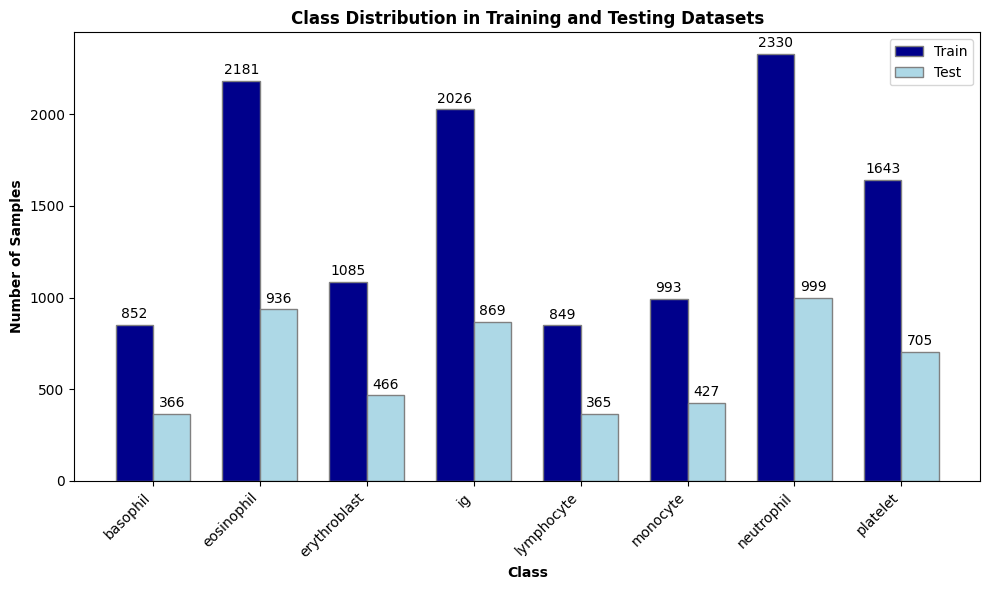

In [19]:
# Step 1: Count the samples in each class
class_counts = {}
for label in np.unique(labels):
    class_counts[label] = np.sum(labels == label)

# Step 2: Determine the desired split ratio
split_ratio = 0.7  # 70% for training, 30% for testing

# Step 3: Calculate the number of samples for each split
train_class_counts = {label: int(count * split_ratio) for label, count in class_counts.items()}
test_class_counts = {label: count - train_class_counts[label] for label, count in class_counts.items()}

# Step 4: Stratified sampling
train_indices = []
test_indices = []
for label in np.unique(labels):
    label_indices = np.where(labels == label)[0]
    train_label_indices, test_label_indices = train_test_split(label_indices,
                                                              train_size=train_class_counts[label],
                                                              test_size=test_class_counts[label],
                                                              stratify=labels[label_indices])
    train_indices.extend(train_label_indices)
    test_indices.extend(test_label_indices)

# Step 5: Create training and testing datasets
X_train, X_test = images[train_indices], images[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]

# Combine images and labels for training set
train_dataset = list(zip(X_train, y_train))

# Combine images and labels for testing set
test_dataset = list(zip(X_test, y_test))


# Plotting the class distribution for both training and testing datasets
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
r1 = np.arange(len(train_classes))
r2 = [x + bar_width for x in r1]

ax.bar(r1, train_counts, color='darkblue', width=bar_width, edgecolor='grey', label='Train')
ax.bar(r2, test_counts, color='lightblue', width=bar_width, edgecolor='grey', label='Test')

for i, count in enumerate(train_counts):
    ax.text(r1[i], count + 20, str(count), ha='center', va='bottom')
for i, count in enumerate(test_counts):
    ax.text(r2[i], count + 20, str(count), ha='center', va='bottom')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Number of Samples', fontweight='bold')
ax.set_xticks([r + bar_width/2 for r in range(len(train_classes))])
ax.set_xticklabels(train_classes, rotation=45, ha='right')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Number of Samples', fontweight='bold')
ax.set_title('Class Distribution in Training and Testing Datasets', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()



In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import confusion_matrix

# Dataset paths
dataset_path = 'C:\\Users\\anu\\Downloads\\bloodcells_dataset'

# Get all image filenames and labels
image_files = []
labels = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png"):
            image_files.append(os.path.join(root, file))
            labels.append(root.split("/")[-1])

# Determine the number of classes dynamically
num_classes = len(set(labels))

# Split data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Data generators with data augmentation
batch_size = 32
image_size = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": train_files, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": test_files, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# U-Net model architecture
def unet_model(input_size=(128, 128, 3), classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Add more convolutional and pooling layers as needed following the U-Net architecture
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flat = Flatten()(pool3)
    dense = Dense(512, activation='relu')(flat)
    outputs = Dense(classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and compile the model
model = unet_model(input_size=(*image_size, 3), classes=num_classes)
model.summary()

# Calculate the number of validation samples and steps per epoch
num_validation_samples = len(test_files)
validation_steps = num_validation_samples // batch_size
validation_steps = max(validation_steps, 1)

# Train the model using the calculated validation steps
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_files) // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps)

# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict classes for test data
test_predictions = model.predict(validation_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Get true classes for test data
true_classes = validation_generator.classes

# Compute overall confusion matrix
overall_cm = confusion_matrix(true_classes, test_predictions_classes)

print(overall_cm)

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(overall_cm)
incorrect_counts = np.sum(overall_cm, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(validation_generator.class_indices.keys()):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")


Found 13673 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,704,456 (132.39 MB)

 Trainable params: 34,704,456 (132.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


C:\Users\anu\anaconda3\envs\datascience\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


427/427 ━━━━━━━━━━━━━━━━━━━━ 1970s 5s/step - accuracy: 0.5229 - loss: 1.7540 - val_accuracy: 0.8054 - val_loss: 0.6244
Epoch 2/30
  1/427 ━━━━━━━━━━━━━━━━━━━━ 31:52 4s/step - accuracy: 0.8438 - loss: 0.4760

C:\Users\anu\anaconda3\envs\datascience\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8438 - loss: 0.2386 - val_accuracy: 0.8148 - val_loss: 0.2438
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1971s 5s/step - accuracy: 0.8620 - loss: 0.3904 - val_accuracy: 0.8965 - val_loss: 0.2927
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8438 - loss: 0.2077 - val_accuracy: 1.0000 - val_loss: 0.0578
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1980s 5s/step - accuracy: 0.9026 - loss: 0.2827 - val_accuracy: 0.8806 - val_loss: 0.3560
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8750 - loss: 0.1165 - val_accuracy: 0.9259 - val_loss: 0.1340
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1811s 4s/step - accuracy: 0.9227 - loss: 0.2211 - val_accuracy: 0.8676 - val_loss: 0.4052
Epoch 8/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9375 - loss: 0.0587 - val_accuracy: 0.8889 - val_loss: 0.1137
Epoch 9/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1504s 4s/step - accuracy: 0.9440 - loss: 0.1642 - val_accuracy: 0.860

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(true_classes, test_predictions_classes, average='weighted')
overall_recall = recall_score(true_classes, test_predictions_classes, average='weighted')
overall_f1_score = f1_score(true_classes, test_predictions_classes, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1 Score:", overall_f1_score)


Overall Precision: 0.14217201531295745
Overall Recall: 0.14390172565077508
Overall F1 Score: 0.14283172907253536


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import confusion_matrix

# Dataset paths
dataset_path = 'C:\\Users\\anu\\Downloads\\bloodcells_dataset'

# Get all image filenames and labels
image_files = []
labels = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png"):
            image_files.append(os.path.join(root, file))
            labels.append(root.split("/")[-1])

# Determine the number of classes dynamically
num_classes = len(set(labels))

# Split data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Data generators with data augmentation
batch_size = 32
image_size = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Shuffle the training dataframe
train_df = pd.DataFrame({"filename": train_files, "class": train_labels})
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Create the data generator for training with shuffled dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# Validation generator remains the same
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": test_files, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# U-Net model architecture
def unet_model(input_size=(128, 128, 3), classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Add more convolutional and pooling layers as needed following the U-Net architecture
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flat = Flatten()(pool3)
    dense = Dense(512, activation='relu')(flat)
    outputs = Dense(classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and compile the model
model = unet_model(input_size=(*image_size, 3), classes=num_classes)
model.summary()

# Calculate the number of validation samples and steps per epoch
num_validation_samples = len(test_files)
validation_steps = num_validation_samples // batch_size
validation_steps = max(validation_steps, 1)

# Train the model using the calculated validation steps
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_files) // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps)

# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict classes for test data
test_predictions = model.predict(validation_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Get true classes for test data

true_classes = validation_generator.classes

# Compute overall confusion matrix
overall_cm = confusion_matrix(true_classes, test_predictions_classes)

print(overall_cm)

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(overall_cm)
incorrect_counts = np.sum(overall_cm, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(validation_generator.class_indices.keys()):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")


Found 13673 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,704,456 (132.39 MB)

 Trainable params: 34,704,456 (132.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


C:\Users\anu\anaconda3\envs\datascience\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


427/427 ━━━━━━━━━━━━━━━━━━━━ 3399s 8s/step - accuracy: 0.5090 - loss: 1.6314 - val_accuracy: 0.8346 - val_loss: 0.4549
Epoch 2/30
  1/427 ━━━━━━━━━━━━━━━━━━━━ 46:10 7s/step - accuracy: 0.8750 - loss: 0.2246

C:\Users\anu\anaconda3\envs\datascience\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


427/427 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8750 - loss: 0.1126 - val_accuracy: 0.7037 - val_loss: 0.2834
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 3041s 7s/step - accuracy: 0.8639 - loss: 0.3937 - val_accuracy: 0.8113 - val_loss: 0.6582
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.7037 - val_loss: 0.7423
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 3615s 8s/step - accuracy: 0.9043 - loss: 0.2724 - val_accuracy: 0.9068 - val_loss: 0.2757
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9375 - loss: 0.0652 - val_accuracy: 0.9259 - val_loss: 0.0752
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 3628s 8s/step - accuracy: 0.9314 - loss: 0.2020 - val_accuracy: 0.8423 - val_loss: 0.4593
Epoch 8/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.8519 - val_loss: 0.1963
Epoch 9/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 2948s 7s/step - accuracy: 0.9387 - loss: 0.1754 - val_accuracy: 

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(true_classes, test_predictions_classes, average='weighted')
overall_recall = recall_score(true_classes, test_predictions_classes, average='weighted')
overall_f1_score = f1_score(true_classes, test_predictions_classes, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1 Score:", overall_f1_score)


Overall Precision: 0.15570967870653254
Overall Recall: 0.15501608657502194
Overall F1 Score: 0.15518327264878604
